In [1]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import sem
import os
import scipy
from scipy.integrate import odeint
import scipy.integrate as integ

SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE, family='sans-serif', serif='Arial')          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('text')

from matplotlib.ticker import MaxNLocator
my_locator = MaxNLocator(6)
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#053061', '#f4a582']

def figure_size_setting(WIDTH):
    #WIDTH = 700.0  # the number latex spits out
    FACTOR = 0.8  # the fraction of the width you'd like the figure to occupy
    fig_width_pt  = WIDTH * FACTOR
    inches_per_pt = 1.0 / 72.27
    golden_ratio  = (np.sqrt(5) - 1.0) / 2.0  # because it looks good
    fig_width_in  = fig_width_pt * inches_per_pt  # figure width in inches
    fig_height_in = fig_width_in * golden_ratio   # figure height in inches
    fig_dims    = [fig_width_in, fig_height_in] # fig dims as a list
    return fig_dims


## Fluctuations in supplied essential resources

In [2]:
R_pool_presampled_ori =  np.array([[0.        , 0.        , 0.        ],
                                   [0.        , 0.56      , 0.56      ],
                                   [0.56      , 0.18666667, 0.93333333],
                                   [1.12      , 0.74666667, 0.37333333],
                                   [0.        , 1.30666667, 1.30666667],
                                   [0.09333333, 0.18666667, 2.33333333],
                                   [1.86666667, 1.86666667, 0.18666667],
                                   [0.46666667, 2.24      , 1.30666667],
                                   [1.4       , 0.46666667, 2.33333333],
                                   [2.98666667, 1.68      , 0.46666667]])
R_pool_presampled = R_pool_presampled_ori.copy()

In [3]:
def model_simulation_without_fluctuation(dt, D, t_sim, B0, R0, R_pool, distribution_of_enzymes_array, cost_array, production_ratio_array, stoichiometry_array):
    B = B0.copy()
    R = R0.copy()
    B_t = np.zeros((t_sim+1, B.shape[0]))
    R_t = np.zeros((t_sim+1, R.shape[0]))
    B_t[0] = B; R_t[0] = R;

    def dydt(t, y):
        dydt = np.zeros([NumOfSpecies+1+NumOfAminoAcids])
        B = y[:NumOfSpecies]
        R = y[NumOfSpecies:]

        growth_rate_all = np.zeros(NumOfSpecies)
        consumption_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
        uptake_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
        production_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids))

        converted_fluxes = (distribution_of_enzymes_array / cost_array)[:,0][:,np.newaxis] * production_ratio_array * R[0]
        uptake_fluxes[:,1:] = (distribution_of_enzymes_array / cost_array)[:,1:] * R[1:]

        limiting_fluxes = np.min((converted_fluxes + uptake_fluxes[:,1:]) / stoichiometry_array, 1)
        consumption_fluxes[:,1:] = stoichiometry_array * limiting_fluxes[:,np.newaxis]
        growth_rate_all = np.sum(consumption_fluxes[:,1:], 1)
        consumption_fluxes[:,0] = converted_fluxes.sum(1)
        uptake_fluxes[:,0] = consumption_fluxes[:,0]

        production_fluxes = (converted_fluxes + uptake_fluxes[:,1:]) - consumption_fluxes[:,1:]

        dBdt = B * growth_rate_all - D * B
        dRdt = - np.dot(B, (uptake_fluxes)) - D * R + D * R_pool
        dRdt[1:] = dRdt[1:] + np.dot(B, (production_fluxes))

        dydt[:NumOfSpecies] = dBdt
        dydt[NumOfSpecies:] = dRdt

        return dydt

    y0 = np.zeros([NumOfSpecies+1+NumOfAminoAcids])
    y0[:NumOfSpecies] = B_t[0]
    y0[NumOfSpecies:] = R_t[0]

    t_min=0
    t_max=t_sim
    solution=integ.LSODA(dydt,t_min,y0,t_max)
    solution=integ.solve_ivp(dydt,[t_min, t_max],y0,method='LSODA', atol=1e-4, rtol=1e-6)
    ts = solution.t
    Ps = solution.y.transpose()

    B_t = Ps[:,:NumOfSpecies]
    R_t = Ps[:,NumOfSpecies:]

    y = Ps[-1, :]
    B = y[:NumOfSpecies]
    R = y[NumOfSpecies:]

    growth_rate_all = np.zeros(NumOfSpecies)
    consumption_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
    uptake_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
    production_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids))
    converted_fluxes = (distribution_of_enzymes_array / cost_array)[:,0][:,np.newaxis] * production_ratio_array * R[0]
    uptake_fluxes[:,1:] = (distribution_of_enzymes_array / cost_array)[:,1:] * R[1:]
    limiting_fluxes = np.min((converted_fluxes + uptake_fluxes[:,1:]) / stoichiometry_array, 1)
    consumption_fluxes[:,1:] = stoichiometry_array * limiting_fluxes[:,np.newaxis]
    growth_rate_all = np.sum(consumption_fluxes[:,1:], 1)
    consumption_fluxes[:,0] = converted_fluxes.sum(1)
    uptake_fluxes[:,0] = consumption_fluxes[:,0]
    production_fluxes = (converted_fluxes + uptake_fluxes[:,1:]) - consumption_fluxes[:,1:]

    i_survivors = np.where(B > 0.001)[0]
    mono_growth_rates = distribution_of_enzymes_array[:,0] * np.min(production_ratio_array / stoichiometry_array, 1) * R_pool[0]
    rank = np.argsort(np.argsort(mono_growth_rates)[::-1]) + 1
    rank_of_survivors = rank[i_survivors]

    return ts, B_t, R_t

In [4]:
def model_simulation_with_fluctuation(dt, D, t_sim, B0, R0, R_pool, distribution_of_enzymes_array, cost_array, production_ratio_array, stoichiometry_array):
    B = B0.copy()
    R = R0.copy()
    B_t = np.zeros((t_sim+1, B.shape[0]))
    R_t = np.zeros((t_sim+1, R.shape[0]))
    B_t[0] = B; R_t[0] = R;

    production_ratio_array_ori = production_ratio_array.copy()
    for i in range(10):
        if i==0:
            R_pool = np.zeros(NumOfAminoAcids+1); R_pool[0] = 10; R_pool[1:] = R_pool_presampled[i,:]
        else:
            R_pool = np.zeros(NumOfAminoAcids+1); R_pool[0] = 10; R_pool[1:] = R_pool_presampled[i,:]; R_pool[0] = R_pool[0] - np.sum(R_pool[1:])
        def dydt(t, y):
            dydt = np.zeros([NumOfSpecies+1+NumOfAminoAcids])
            B = y[:NumOfSpecies]
            R = y[NumOfSpecies:]

            growth_rate_all = np.zeros(NumOfSpecies)
            consumption_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
            uptake_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
            production_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids))

            converted_fluxes = (distribution_of_enzymes_array / cost_array)[:,0][:,np.newaxis] * production_ratio_array * R[0]
            uptake_fluxes[:,1:] = (distribution_of_enzymes_array / cost_array)[:,1:] * R[1:]

            limiting_fluxes = np.min((converted_fluxes + uptake_fluxes[:,1:]) / stoichiometry_array, 1)
            consumption_fluxes[:,1:] = stoichiometry_array * limiting_fluxes[:,np.newaxis]
            growth_rate_all = np.sum(consumption_fluxes[:,1:], 1)
            consumption_fluxes[:,0] = converted_fluxes.sum(1)
            uptake_fluxes[:,0] = consumption_fluxes[:,0]

            production_fluxes = (converted_fluxes + uptake_fluxes[:,1:]) - consumption_fluxes[:,1:]

            dBdt = B * growth_rate_all - D * B
            dRdt = - np.dot(B, (uptake_fluxes)) - D * R + D * R_pool
            dRdt[1:] = dRdt[1:] + np.dot(B, (production_fluxes))
            dBdt[y[:NumOfSpecies] < 1e-3] = 0
            B[y[:NumOfSpecies] < 1e-3] = 0
            y[:NumOfSpecies] = B[:]

            dydt[:NumOfSpecies] = dBdt
            dydt[NumOfSpecies:] = dRdt

            return dydt

        y0 = np.zeros([NumOfSpecies+1+NumOfAminoAcids])
        y0[:NumOfSpecies] = B
        y0[NumOfSpecies:] = R

        t_min = 0
        t_max = (t_sim/10)
        solution=integ.LSODA(dydt,t_min,y0,t_max)
        solution=integ.solve_ivp(dydt,[t_min, t_max],y0,method='LSODA', atol=1e-4, rtol=1e-6)
        ts_temp = solution.t
        Ps_temp = solution.y.transpose()
        y = Ps_temp[-1, :]
        B = y[:NumOfSpecies]
        R = y[NumOfSpecies:]

        if i == 0:
            ts = ts_temp.copy()
            Ps = Ps_temp.copy()
        else:
            ts = np.concatenate([ts, np.array([ts_temp[-1]])+t_max*i])
            Ps = np.concatenate([Ps, np.array(Ps_temp[-1:,:])])

    B_t = Ps[:,:NumOfSpecies]
    R_t = Ps[:,NumOfSpecies:]

    y = Ps[-1, :]
    B = y[:NumOfSpecies]
    R = y[NumOfSpecies:]

    growth_rate_all = np.zeros(NumOfSpecies)
    consumption_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
    uptake_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids+1))
    production_fluxes = np.ones((NumOfSpecies, NumOfAminoAcids))
    converted_fluxes = (distribution_of_enzymes_array / cost_array)[:,0][:,np.newaxis] * production_ratio_array * R[0]
    uptake_fluxes[:,1:] = (distribution_of_enzymes_array / cost_array)[:,1:] * R[1:]
    limiting_fluxes = np.min((converted_fluxes + uptake_fluxes[:,1:]) / stoichiometry_array, 1)
    consumption_fluxes[:,1:] = stoichiometry_array * limiting_fluxes[:,np.newaxis]
    growth_rate_all = np.sum(consumption_fluxes[:,1:], 1)
    consumption_fluxes[:,0] = converted_fluxes.sum(1)
    uptake_fluxes[:,0] = consumption_fluxes[:,0]
    production_fluxes = (converted_fluxes + uptake_fluxes[:,1:]) - consumption_fluxes[:,1:]
    
    return ts, B_t, R_t

## Slightly dissimilar species (small covered area)

In [5]:
NumOfAminoAcids = 3
NumOfSpecies = 3

B0 = np.ones(NumOfSpecies)
R0 = np.zeros(NumOfAminoAcids+1); R0[0] = 1
R_pool = np.zeros(NumOfAminoAcids+1); R_pool[0] = 10
B = B0.copy()
R = R0.copy()

distribution_of_enzymes_array = np.ones((NumOfSpecies, NumOfAminoAcids+1)) # the first one is the transformation of the primary resource
distribution_of_enzymes_array = distribution_of_enzymes_array / np.sum(distribution_of_enzymes_array, 1)[:, np.newaxis]
cost_array = np.ones((NumOfSpecies, NumOfAminoAcids+1))  # the first one is the transformation of the primary resource
production_ratio_array = np.ones((NumOfSpecies, NumOfAminoAcids))
production_ratio_array = production_ratio_array / np.sum(production_ratio_array, 1)[:, np.newaxis]
pr = 0.38
production_ratio_array[:3, :] = np.array([[1-2*pr,pr,pr],[pr,1-2*pr,pr],[pr,pr,1-2*pr]])
stoichiometry_array = np.ones((NumOfSpecies, NumOfAminoAcids))
stoichiometry_array = stoichiometry_array / np.sum(stoichiometry_array, 1)[:, np.newaxis]


In [6]:
dt = 0.1
D = 0.2
t_sim = 2000

ts1_list, B_t1_list, R_t1_list = [], [], []
ts2_list, B_t2_list, R_t2_list = [], [], []
production_ratio_array_list = []
production_ratio_array_list += [production_ratio_array];
ts1, B_t1, R_t1 = model_simulation_without_fluctuation(dt, D, t_sim, B0, R0, R_pool, distribution_of_enzymes_array, cost_array, production_ratio_array, stoichiometry_array);
ts2, B_t2, R_t2 = model_simulation_with_fluctuation(dt, D, t_sim, B0, R0, R_pool, distribution_of_enzymes_array, cost_array, production_ratio_array, stoichiometry_array);
ts1_list += [ts1]; B_t1_list += [B_t1]; R_t1_list += [R_t1];
ts2_list += [ts2]; B_t2_list += [B_t2]; R_t2_list += [R_t2];

/Users/tongwang/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


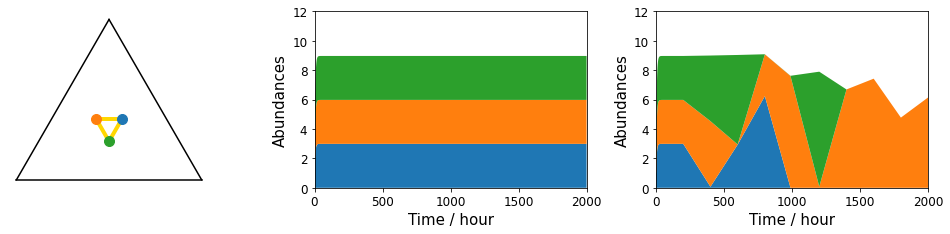

In [7]:
fig_dims = figure_size_setting(500)
fig_dims = [fig_dims[0]*2.5, fig_dims[1]]
fig, axes = plt.subplots(1, 3, figsize=fig_dims)

ax = axes[0]
for i_species1, i_species2 in zip([0,0,1],[1,2,2]):
    [x1,y1,z1] = production_ratio_array[i_species1,:]
    [x2,y2,z2] = production_ratio_array[i_species2,:]
    ax.plot([0.5-x1-0.5*z1, 0.5-x2-0.5*z2], [np.sqrt(3)/2*z1, np.sqrt(3)/2*z2], '-', color='gold', lw=4) 
for i in range(NumOfSpecies):
    [x,y,z] = production_ratio_array[i,:]
    ax.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'o', color=color_list[i], markersize=10, alpha=1) 
ax.plot([-0.5,0.5],[0,0],'k-')
ax.plot([0.5,0],[0,np.sqrt(3)/2],'k-')
ax.plot([0,-0.5],[np.sqrt(3)/2,0],'k-')
ax.set_aspect(aspect='equal')
ax.set_axis_off()

ax = axes[1]
ax.stackplot(ts1, (B_t1).transpose(), colors=color_list)
ax.set_xlabel('Time / hour')
ax.set_ylabel('Abundances')
ax.set_xlim([0.0, 2e3])
ax.set_ylim([0.0, 12])
ax.margins(0, 0) # Set margins to avoid "whitespace"

ax = axes[2]
ax.stackplot(ts2, (B_t2).transpose(), colors=color_list)
ax.set_xlabel('Time / hour')
ax.set_ylabel('Abundances')
ax.set_xlim([0.0, 2e3])
ax.set_ylim([0.0, 12])
ax.margins(0, 0) # Set margins to avoid "whitespace"

fig.tight_layout()
#fig.savefig('./figures/SI figures/SI_Fig3c2.pdf', dpi=300)


## Single auxotrophy (middle covered area)

In [8]:
NumOfAminoAcids = 3
NumOfSpecies = 3

B0 = np.ones(NumOfSpecies)
R0 = np.zeros(NumOfAminoAcids+1); R0[0] = 1
R_pool = np.zeros(NumOfAminoAcids+1); R_pool[0] = 10
B = B0.copy()
R = R0.copy()

distribution_of_enzymes_array = np.ones((NumOfSpecies, NumOfAminoAcids+1)) # the first one is the transformation of the primary resource
distribution_of_enzymes_array = distribution_of_enzymes_array / np.sum(distribution_of_enzymes_array, 1)[:, np.newaxis]
cost_array = np.ones((NumOfSpecies, NumOfAminoAcids+1))  # the first one is the transformation of the primary resource
production_ratio_array = np.ones((NumOfSpecies, NumOfAminoAcids))
production_ratio_array = production_ratio_array / np.sum(production_ratio_array, 1)[:, np.newaxis]
pr = 0.5
production_ratio_array[:3, :] = np.array([[1-2*pr,pr,pr],[pr,1-2*pr,pr],[pr,pr,1-2*pr]])
stoichiometry_array = np.ones((NumOfSpecies, NumOfAminoAcids))
stoichiometry_array = stoichiometry_array / np.sum(stoichiometry_array, 1)[:, np.newaxis]


In [9]:
dt = 0.1
D = 0.2
t_sim = 2000

production_ratio_array_list += [production_ratio_array];
ts1, B_t1, R_t1 = model_simulation_without_fluctuation(dt, D, t_sim, B0, R0, R_pool, distribution_of_enzymes_array, cost_array, production_ratio_array, stoichiometry_array);
ts2, B_t2, R_t2 = model_simulation_with_fluctuation(dt, D, t_sim, B0, R0, R_pool, distribution_of_enzymes_array, cost_array, production_ratio_array, stoichiometry_array);
ts1_list += [ts1]; B_t1_list += [B_t1]; R_t1_list += [R_t1];
ts2_list += [ts2]; B_t2_list += [B_t2]; R_t2_list += [R_t2];

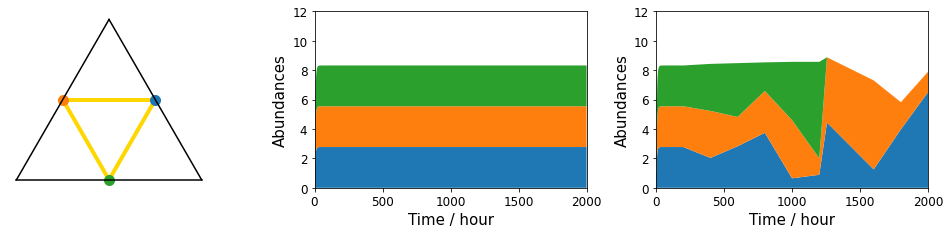

In [10]:
fig_dims = figure_size_setting(500)
fig_dims = [fig_dims[0]*2.5, fig_dims[1]]
fig, axes = plt.subplots(1, 3, figsize=fig_dims)

ax = axes[0]
for i_species1, i_species2 in zip([0,0,1],[1,2,2]):
    [x1,y1,z1] = production_ratio_array[i_species1,:]
    [x2,y2,z2] = production_ratio_array[i_species2,:]
    ax.plot([0.5-x1-0.5*z1, 0.5-x2-0.5*z2], [np.sqrt(3)/2*z1, np.sqrt(3)/2*z2], '-', color='gold', lw=4) 
for i in range(NumOfSpecies):
    [x,y,z] = production_ratio_array[i,:]
    ax.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'o', color=color_list[i], markersize=10, alpha=1) 
ax.plot([-0.5,0.5],[0,0],'k-')
ax.plot([0.5,0],[0,np.sqrt(3)/2],'k-')
ax.plot([0,-0.5],[np.sqrt(3)/2,0],'k-')
ax.set_aspect(aspect='equal')
ax.set_axis_off()

ax = axes[1]
ax.stackplot(ts1, (B_t1).transpose(), colors=color_list)
ax.set_xlabel('Time / hour')
ax.set_ylabel('Abundances')
ax.set_xlim([0.0, 2e3])
ax.set_ylim([0.0, 12])
ax.margins(0, 0) # Set margins to avoid "whitespace"

ax = axes[2]
ax.stackplot(ts2, (B_t2).transpose(), colors=color_list)
ax.set_xlabel('Time / hour')
ax.set_ylabel('Abundances')
ax.set_xlim([0.0, 2e3])
ax.set_ylim([0.0, 12])
ax.margins(0, 0) # Set margins to avoid "whitespace"

fig.tight_layout()
#fig.savefig('./figures/SI figures/SI_Fig3c2.pdf', dpi=300)


## Auxotrophs (largest dissimilarity and largest covered area)

In [11]:
NumOfAminoAcids = 3
NumOfSpecies = 3

B0 = np.ones(NumOfSpecies)
R0 = np.zeros(NumOfAminoAcids+1); R0[0] = 1
R_pool = np.zeros(NumOfAminoAcids+1); R_pool[0] = 10
B = B0.copy()
R = R0.copy()

distribution_of_enzymes_array = np.ones((NumOfSpecies, NumOfAminoAcids+1)) # the first one is the transformation of the primary resource
distribution_of_enzymes_array = distribution_of_enzymes_array / np.sum(distribution_of_enzymes_array, 1)[:, np.newaxis]
cost_array = np.ones((NumOfSpecies, NumOfAminoAcids+1))  # the first one is the transformation of the primary resource
production_ratio_array = np.ones((NumOfSpecies, NumOfAminoAcids))
production_ratio_array = production_ratio_array / np.sum(production_ratio_array, 1)[:, np.newaxis]
production_ratio_array[:3, :] = np.array([[1.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]])
stoichiometry_array = np.ones((NumOfSpecies, NumOfAminoAcids))
stoichiometry_array = stoichiometry_array / np.sum(stoichiometry_array, 1)[:, np.newaxis]


In [12]:
dt = 0.1
D = 0.2
t_sim = 2000

production_ratio_array_list += [production_ratio_array];
ts1, B_t1, R_t1 = model_simulation_without_fluctuation(dt, D, t_sim, B0, R0, R_pool, distribution_of_enzymes_array, cost_array, production_ratio_array, stoichiometry_array);
ts2, B_t2, R_t2 = model_simulation_with_fluctuation(dt, D, t_sim, B0, R0, R_pool, distribution_of_enzymes_array, cost_array, production_ratio_array, stoichiometry_array);
ts1_list += [ts1]; B_t1_list += [B_t1]; R_t1_list += [R_t1];
ts2_list += [ts2]; B_t2_list += [B_t2]; R_t2_list += [R_t2];

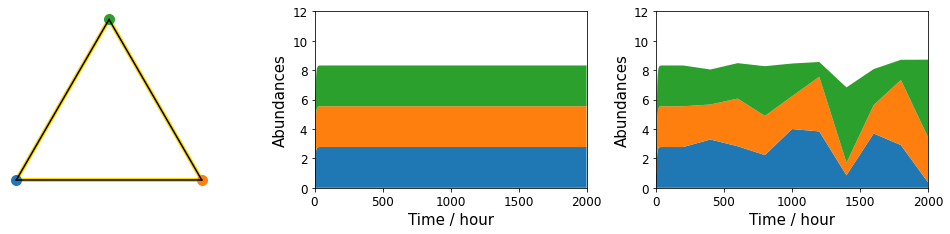

In [13]:
fig_dims = figure_size_setting(500)
fig_dims = [fig_dims[0]*2.5, fig_dims[1]]
fig, axes = plt.subplots(1, 3, figsize=fig_dims)

ax = axes[0]
for i_species1, i_species2 in zip([0,0,1],[1,2,2]):
    [x1,y1,z1] = production_ratio_array[i_species1,:]
    [x2,y2,z2] = production_ratio_array[i_species2,:]
    ax.plot([0.5-x1-0.5*z1, 0.5-x2-0.5*z2], [np.sqrt(3)/2*z1, np.sqrt(3)/2*z2], '-', color='gold', lw=4) 
for i in range(NumOfSpecies):
    [x,y,z] = production_ratio_array[i,:]
    ax.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'o', color=color_list[i], markersize=10, alpha=1) 
ax.plot([-0.5,0.5],[0,0],'k-')
ax.plot([0.5,0],[0,np.sqrt(3)/2],'k-')
ax.plot([0,-0.5],[np.sqrt(3)/2,0],'k-')
ax.set_aspect(aspect='equal')
ax.set_axis_off()

ax = axes[1]
ax.stackplot(ts1, (B_t1).transpose(), colors=color_list)
ax.set_xlabel('Time / hour')
ax.set_ylabel('Abundances')
ax.set_xlim([0.0, 2e3])
ax.set_ylim([0.0, 12])
ax.margins(0, 0) # Set margins to avoid "whitespace"

ax = axes[2]
ax.stackplot(ts2, (B_t2).transpose(), colors=color_list)
ax.set_xlabel('Time / hour')
ax.set_ylabel('Abundances')
ax.set_xlim([0.0, 2e3])
ax.set_ylim([0.0, 12])
ax.margins(0, 0) # Set margins to avoid "whitespace"

fig.tight_layout()
#fig.savefig('./figures/SI figures/SI_Fig3c2.pdf', dpi=300)


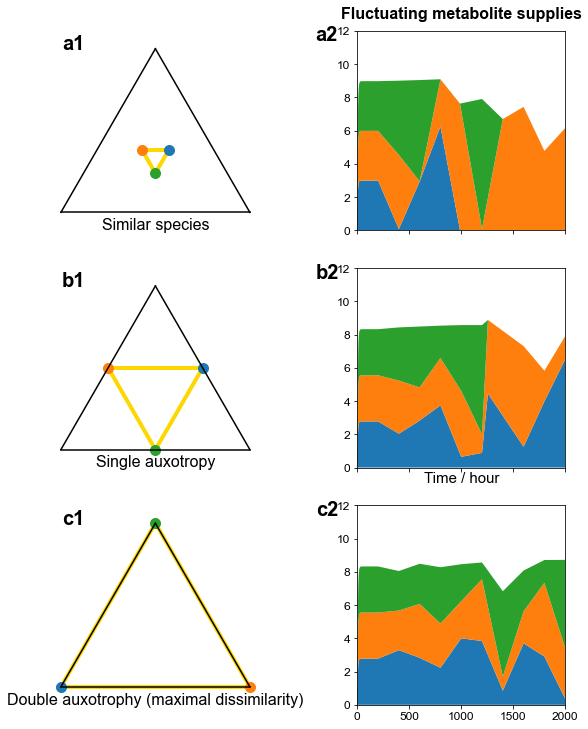

In [14]:
from scipy import stats
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Arial'] + plt.rcParams['font.serif']
plt.rcParams['mathtext.default'] = 'regular'

fig_dims = figure_size_setting(500)
fig_dims = [fig_dims[0]*1.5, fig_dims[1]*3]
fig, axes = plt.subplots(3, 2, figsize=fig_dims, sharex='col')

fig_labels = ["a", "b", "c"]
fig_texts = ["Similar species", "Single auxotropy", "Double auxotrophy (maximal dissimilarity)"]
for i_plot in range(3):
    ts1 = ts1_list[i_plot]; B_t1 = B_t1_list[i_plot]
    ts2 = ts2_list[i_plot]; B_t2 = B_t2_list[i_plot]
    production_ratio_array = production_ratio_array_list[i_plot]
    ax = axes[i_plot,0]
    #### feasibility region
    for i_species1, i_species2 in zip([0,0,1],[1,2,2]):
        [x1,y1,z1] = production_ratio_array[i_species1,:]
        [x2,y2,z2] = production_ratio_array[i_species2,:]
        ax.plot([0.5-x1-0.5*z1, 0.5-x2-0.5*z2], [np.sqrt(3)/2*z1, np.sqrt(3)/2*z2], '-', color='gold', lw=4) 
    for i in range(NumOfSpecies):
        [x,y,z] = production_ratio_array[i,:]
        ax.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, 'o', color=color_list[i], markersize=10, alpha=1) 
    ax.plot([-0.5,0.5],[0,0],'k-')
    ax.plot([0.5,0],[0,np.sqrt(3)/2],'k-')
    ax.plot([0,-0.5],[np.sqrt(3)/2,0],'k-')  
    ax.set_aspect(aspect='equal')
    ax.set_axis_off()
    ax.text(0.05, 0.95, fig_labels[i_plot]+str(1), transform=ax.transAxes, fontsize=20, fontweight='bold')
    ax.text(0.5, -0.05, fig_texts[i_plot], transform=ax.transAxes, fontsize=16, ha='center')

    ax = axes[i_plot,1]
    ax.stackplot(ts2, (B_t2).transpose(), colors=color_list)
    if i_plot == 1:
        ax.set_xlabel('Time / hour')
    ax.set_xlim([0.0, 2e3])
    ax.set_ylim([0.0, 12])
    ax.margins(0, 0) # Set margins to avoid "whitespace"
    ax.text(-0.2, 0.95, fig_labels[i_plot]+str(2), transform=ax.transAxes, fontsize=20, fontweight='bold')
    if i_plot == 0:
        ax.text(0.5, 1.06, 'Fluctuating metabolite supplies', transform=ax.transAxes, fontsize=16, ha='center', fontweight='bold')

fig.tight_layout()
#fig.savefig('./figures/metabolite_fluctuation.pdf', dpi=300)


In [15]:
########### import the pickled file
import pickle
pickle_in = open("simulation_repeats.pickle","rb")
[NumOfSpecies, NumOfAminoAcids, R_pool_presampled_ori, ts1_list, ts2_list, B_t1_list, B_t2_list, production_ratio_array_list, area_size_array, fluc_mag_array, n_survivors_array] = pickle.load(pickle_in)


1
[0.45513738 0.48677539 0.49555652]
2
[0.39443218 0.37302749 0.43143255]
3
[0.26350842 0.25542236 0.27189611]


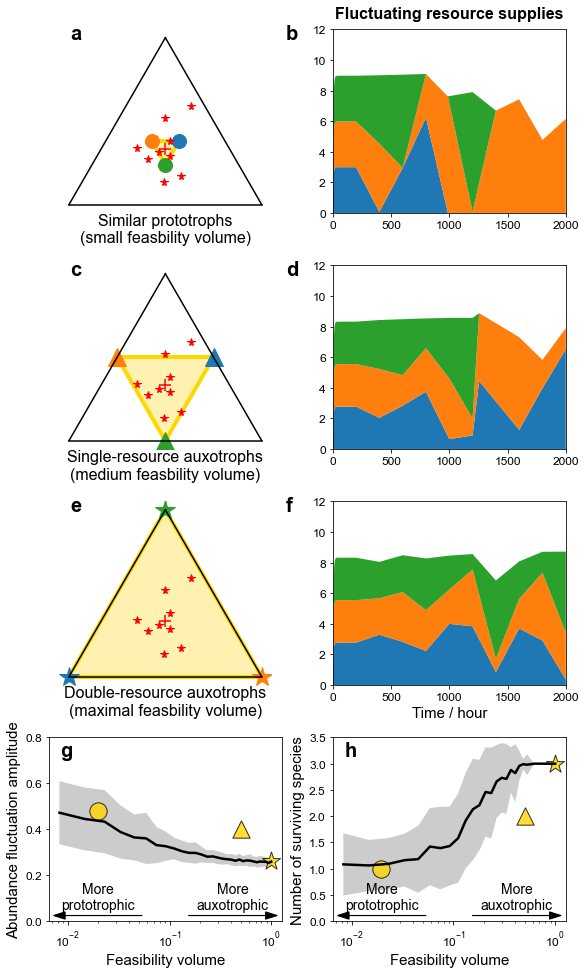

In [16]:
from scipy import stats
import matplotlib.patches as patches
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Arial'] + plt.rcParams['font.serif']
plt.rcParams['mathtext.default'] = 'regular'

fig_dims = figure_size_setting(500)
fig_dims = [fig_dims[0]*1.5, fig_dims[1]*4.0]
fig, axes = plt.subplots(4, 2, figsize=fig_dims)

fig_labels = ["a", "b", "c", "d", "e", "f"]
fig_texts = ["Similar prototrophs\n(small feasbility volume)", "Single-resource auxotrophs\n(medium feasbility volume)", "Double-resource auxotrophs\n(maximal feasbility volume)"]
volume_texts = ["Small feasbility volume", "Medium feasbility volume", "Maximal feasbility volume"]
species_legend = ["o", "^", "*"]
legend_size = [14, 18, 20]
n_survivors_list = []
fluc_mag_list = []

for i_plot in range(3):
    ts1 = ts1_list[i_plot]; B_t1 = B_t1_list[i_plot]
    ts2 = ts2_list[i_plot]; B_t2 = B_t2_list[i_plot]
    n_survivors = np.sum(B_t2[-1,:] > 1e-3)
    fluc_mag = np.std(B_t2, 0) / np.mean(B_t2, 0)
    n_survivors_list = n_survivors_list + [n_survivors]
    fluc_mag_list = fluc_mag_list + [np.mean(fluc_mag)]
    print(n_survivors)
    print(fluc_mag)
    production_ratio_array = production_ratio_array_list[i_plot]
    ax = axes[i_plot,0]
    #### feasibility region
    for i_species1, i_species2 in zip([0,0,1],[1,2,2]):
        [x1,y1,z1] = production_ratio_array[i_species1,:]
        [x2,y2,z2] = production_ratio_array[i_species2,:]
        ax.plot([0.5-x1-0.5*z1, 0.5-x2-0.5*z2], [np.sqrt(3)/2*z1, np.sqrt(3)/2*z2], '-', color='gold', lw=4)
    vertices = []
    for i_species1 in [0,1,2]:
        [x1,y1,z1] = production_ratio_array[i_species1,:]
        vertices += [(0.5-x1-0.5*z1, np.sqrt(3)/2*z1)]
    polygon = plt.Polygon(vertices, closed=True, color='gold', alpha=0.3)
    ax.add_patch(polygon)
    for i in range(NumOfSpecies):
        [x,y,z] = production_ratio_array[i,:]
        ax.plot(0.5-x-0.5*z, np.sqrt(3)/2*z, species_legend[i_plot], color=color_list[i], markersize=legend_size[i_plot], alpha=1)  
    ax.plot(0, 1/3*np.sqrt(3)/2, 'r+', markersize=12, markeredgewidth=1.5, label='stoichiometry vector') 
    for i_R_pool_1 in range(1, R_pool_presampled_ori.shape[0]):
        [x,y,z] = [1/3,1/3,1/3]-(R_pool_presampled_ori/10)[i_R_pool_1]; [x,y,z] = [x,y,z] / np.sum([x,y,z])
        new_loc = [0.5-x-0.5*z, np.sqrt(3)/2*z]
        ax.plot(new_loc[0], new_loc[1], 'r*', ms=8)
        prev_loc = new_loc.copy()
    ax.plot([-0.5,0.5],[0,0],'k-')
    ax.plot([0.5,0],[0,np.sqrt(3)/2],'k-')
    ax.plot([0,-0.5],[np.sqrt(3)/2,0],'k-')  
    ax.set_aspect(aspect='equal')
    ax.set_axis_off()
    ax.text(0.05, 0.95, fig_labels[i_plot*2], transform=ax.transAxes, fontsize=20, fontweight='bold')
    ax.text(0.5, 0.0, fig_texts[i_plot], transform=ax.transAxes, fontsize=16, ha='center', va='top')

    ax = axes[i_plot,1]
    ax.stackplot(ts2, (B_t2).transpose(), colors=color_list)
    if i_plot == 2:
        ax.set_xlabel('Time / hour')
    ax.set_xlim([0.0, 2e3])
    ax.set_ylim([0.0, 12])
    ax.margins(0, 0) # Set margins to avoid "whitespace"
    ax.text(-0.2, 0.95, fig_labels[i_plot*2+1], transform=ax.transAxes, fontsize=20, fontweight='bold')
    if i_plot == 0:
        ax.text(0.5, 1.06, 'Fluctuating resource supplies', transform=ax.transAxes, fontsize=16, ha='center', fontweight='bold')

        
ax = axes[3,0]      
x = area_size_array[:,0][:-2]
y = np.mean(np.mean(fluc_mag_array,2), 1)[:-2]
error = np.std(np.mean(fluc_mag_array,2), 1)[:-2]
ax.plot(x, y, 'k-', lw=2.5)
ax.fill_between(x, y-error, y+error, facecolor='black', alpha=0.2)
ms=300; lw=1; alpha=0.8
ax.scatter(0.0196, fluc_mag_list[0], marker="o", color='gold', alpha=alpha, s=ms, ec='black', lw=lw)
ax.scatter(0.5, fluc_mag_list[1], marker="^", color='gold', s=ms, alpha=alpha, ec='black', lw=lw)
ax.scatter(1, fluc_mag_list[2], marker="*", color='gold', s=ms*1.2, alpha=alpha, ec='black', lw=lw)
ax.set_ylim([0.0,0.8])
ax.set_xscale('log')
ax.set_xlabel('Feasibility volume')
ax.set_ylabel('Abundance fluctuation amplitude')
ax.arrow(0.4, 0.03, -0.33, 0.0, head_width=0.04, head_length=0.05, transform=ax.transAxes, color='black')
ax.text(0.21, 0.05, "More\nprototrophic", transform=ax.transAxes, fontsize=14, va='bottom', ha='center')
ax.arrow(0.6, 0.03, 0.33, 0.0, head_width=0.04, head_length=0.05, transform=ax.transAxes, color='black')
ax.text(0.79, 0.05, "More\nauxotrophic", transform=ax.transAxes, fontsize=14, va='bottom', ha='center')
ax.text(0.05, 0.9, "g", transform=ax.transAxes, fontsize=20, fontweight='bold')

ax = axes[3,1]        
x = area_size_array[:,0][:-2]
y = np.mean(n_survivors_array, 1)[:-2]
error = np.std(n_survivors_array, 1)[:-2]
ax.plot(x, y, 'k-', lw=2.5)
ax.fill_between(x, y-error, y+error, facecolor='black', alpha=0.2)
ax.scatter(0.0196, n_survivors_list[0], marker="o", color='gold', alpha=alpha, s=ms, ec='black', lw=lw)
ax.scatter(0.5, n_survivors_list[1], marker="^", color='gold', s=ms, alpha=alpha, ec='black', lw=lw)
ax.scatter(1, n_survivors_list[2], marker="*", color='gold', s=ms*1.2, alpha=alpha, ec='black', lw=lw)
ax.set_ylim([0.0,3.5])
ax.set_xscale('log')
ax.set_xlabel('Feasibility volume')
ax.set_ylabel('Number of surviving species')
ax.arrow(0.4, 0.03, -0.33, 0.0, head_width=0.04, head_length=0.05, transform=ax.transAxes, color='black')
ax.text(0.21, 0.05, "More\nprototrophic", transform=ax.transAxes, fontsize=14, va='bottom', ha='center')
ax.arrow(0.6, 0.03, 0.33, 0.0, head_width=0.04, head_length=0.05, transform=ax.transAxes, color='black')
ax.text(0.79, 0.05, "More\nauxotrophic", transform=ax.transAxes, fontsize=14, va='bottom', ha='center')
ax.text(0.05, 0.9, "h", transform=ax.transAxes, fontsize=20, fontweight='bold')
        
fig.tight_layout()
#fig.savefig('./figures/Fig_3.pdf', dpi=300)
